# Sim Fit SFR model + F17 lines

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


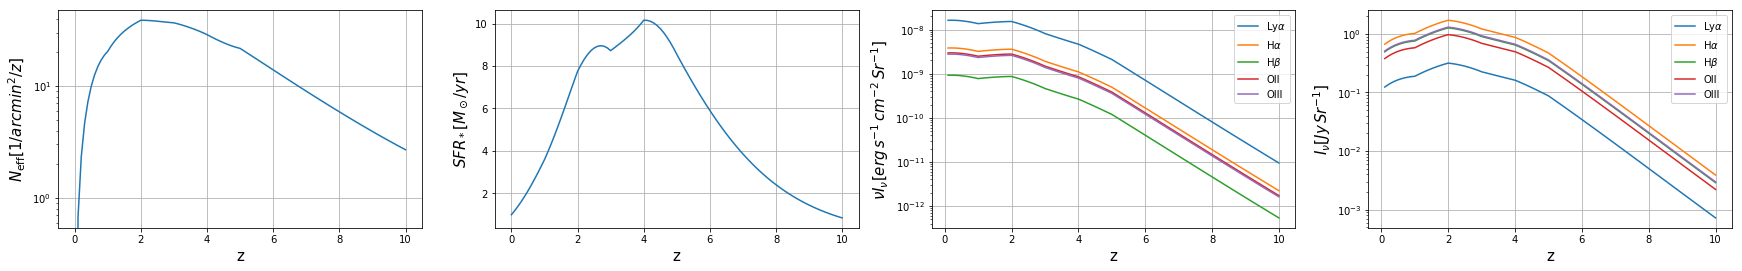

In [131]:
#
from model_F17 import *

dz = 0.1
zbins = np.arange(0,10 + dz,dz)

Neff_arr = np.zeros_like(zbins)
sfrs_arr = np.zeros_like(zbins)
Las_arr = np.zeros_like(zbins)
Has_arr = np.zeros_like(zbins)
Hbs_arr = np.zeros_like(zbins)
O2s_arr = np.zeros_like(zbins)
O3s_arr = np.zeros_like(zbins)

Neffcmv_arr = np.zeros_like(zbins)

df = pd.DataFrame(zbins, columns=['z'])
for i,z in enumerate(zbins):
    Neff = Neff_F17(z, unit = 'obs')
    Neffcmv = Neff_F17(z, unit = 'cmv')
    sfrs = SFRs_F17(z)
    Neff_arr[i] = Neff
    Neffcmv_arr[i] = Neffcmv
    sfrs_arr[i] = sfrs
    Las_arr[i] = Lline_F17('Lya', z, sfr_arr = [sfrs])[0][0]
    Has_arr[i] = Lline_F17('Ha', z, sfr_arr = [sfrs])[0][0]
    Hbs_arr[i] = Lline_F17('Hb', z, sfr_arr = [sfrs])[0][0]
    O2s_arr[i] = Lline_F17('OII', z, sfr_arr = [sfrs])[0][0]
    O3s_arr[i] = Lline_F17('OIII', z, sfr_arr = [sfrs])[0][0]
    
df['Neff'] = Neff_arr
df['SFRs'] = sfrs_arr
df['Lya_Ls'] = Las_arr
df['Ha_Ls'] = Has_arr
df['Hb_Ls'] = Hbs_arr
df['OII_Ls'] = O2s_arr
df['OIII_Ls'] = O3s_arr

df.to_csv('data_internal/F17NeffSFRs.txt',index=False)


# make a plot to compare with F17 paper
fig, ax = plt.subplots(1,4,figsize = (30,4))
ax[0].plot(zbins, Neff_arr)
ax[0].set_yscale('log')
ax[0].set_xlabel('z', fontsize = 15)
ax[0].set_ylabel(r'$N_{\rm eff} [1/arcmin^2/z]$' ,fontsize = 15)
ax[0].grid()
ax[1].plot(zbins, sfrs_arr)
ax[1].set_xlabel('z', fontsize = 15)
ax[1].set_ylabel(r'$SFR_* [M_\odot / yr]$' ,fontsize = 15)
ax[1].grid()

# calculate nuInu
# Inu = (Ls * Neff) *  DA^2 y / (4pi DL^2)
# y = lambda_obs (1+z) / H(z)
# nuInu = (Ls * Neff) *(c * Da^2 * (1+z)) / (4pi * DL^2 * H(z))

cd = cosmo_dist(zbins)
c = const.c * (1 + zbins) * cd.comoving_distance**2 \
    / (cd.H * cosmo.luminosity_distance(zbins)**2 * 4 * np.pi) / u.sr
c = c.to(u.Mpc**3 / u.h**3 / u.sr / u.cm**2)

nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Las_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'Ly$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Has_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Hbs_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\beta$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O2s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OII')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O3s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OIII')
ax[2].set_yscale('log')
ax[2].set_xlabel('z', fontsize = 15)
ax[2].set_ylabel(r'$\nu I_\nu [erg\,s^{-1}\,cm^{-2}\,Sr^{-1}]$' ,fontsize = 15)
ax[2].legend(loc = 0)
ax[2].grid()

nu_obs = (spec_lines.Lya.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'Ly$\alpha$')
nu_obs = (spec_lines.Ha.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\alpha$')
nu_obs = (spec_lines.Hb.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\beta$')
nu_obs = (spec_lines.OII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OII')
nu_obs = (spec_lines.OIII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OIII')
ax[3].set_yscale('log')
ax[3].set_xlabel('z', fontsize = 15)
ax[3].set_ylabel(r'$I_\nu [Jy\,Sr^{-1}]$' ,fontsize = 15)
ax[3].legend(loc = 0)
ax[3].grid()

# Sim Fit SFR model + G17 lines

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


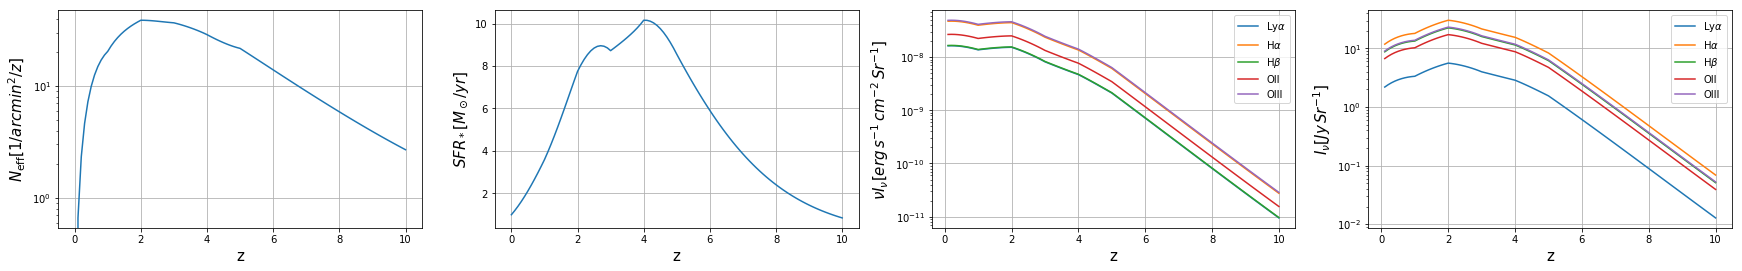

In [2]:
#
from model_F17 import *

dz = 0.1
zbins = np.arange(0,10 + dz,dz)

Neff_arr = np.zeros_like(zbins)
sfrs_arr = np.zeros_like(zbins)
Las_arr = np.zeros_like(zbins)
Has_arr = np.zeros_like(zbins)
Hbs_arr = np.zeros_like(zbins)
O2s_arr = np.zeros_like(zbins)
O3s_arr = np.zeros_like(zbins)

Neffcmv_arr = np.zeros_like(zbins)

df = pd.DataFrame(zbins, columns=['z'])
for i,z in enumerate(zbins):
    Neff = Neff_F17(z, unit = 'obs')
    Neffcmv = Neff_F17(z, unit = 'cmv')
    sfrs = SFRs_F17(z)
    Neff_arr[i] = Neff
    Neffcmv_arr[i] = Neffcmv
    sfrs_arr[i] = sfrs
    Las_arr[i] = Lline_F17('Lya', z, sfr_arr = [sfrs])[0][0]
    Has_arr[i] = Lline_G17('Ha', z, sfr_arr = [sfrs])[0][0]
    Hbs_arr[i] = Lline_G17('Hb', z, sfr_arr = [sfrs])[0][0]
    O2s_arr[i] = Lline_G17('OII', z, sfr_arr = [sfrs])[0][0]
    O3s_arr[i] = Lline_G17('OIII', z, sfr_arr = [sfrs])[0][0]
    
df['Neff'] = Neff_arr
df['SFRs'] = sfrs_arr
df['Lya_Ls'] = Las_arr
df['Ha_Ls'] = Has_arr
df['Hb_Ls'] = Hbs_arr
df['OII_Ls'] = O2s_arr
df['OIII_Ls'] = O3s_arr

df.to_csv('data_internal/F17NeffSFRs.txt',index=False)


# make a plot to compare with F17 paper
fig, ax = plt.subplots(1,4,figsize = (30,4))
ax[0].plot(zbins, Neff_arr)
ax[0].set_yscale('log')
ax[0].set_xlabel('z', fontsize = 15)
ax[0].set_ylabel(r'$N_{\rm eff} [1/arcmin^2/z]$' ,fontsize = 15)
ax[0].grid()
ax[1].plot(zbins, sfrs_arr)
ax[1].set_xlabel('z', fontsize = 15)
ax[1].set_ylabel(r'$SFR_* [M_\odot / yr]$' ,fontsize = 15)
ax[1].grid()

# calculate nuInu
# Inu = (Ls * Neff) *  DA^2 y / (4pi DL^2)
# y = lambda_obs (1+z) / H(z)
# nuInu = (Ls * Neff) *(c * Da^2 * (1+z)) / (4pi * DL^2 * H(z))

cd = cosmo_dist(zbins)
c = const.c * (1 + zbins) * cd.comoving_distance**2 \
    / (cd.H * cosmo.luminosity_distance(zbins)**2 * 4 * np.pi) / u.sr
c = c.to(u.Mpc**3 / u.h**3 / u.sr / u.cm**2)

nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Las_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'Ly$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Has_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Hbs_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\beta$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O2s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OII')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O3s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OIII')
ax[2].set_yscale('log')
ax[2].set_xlabel('z', fontsize = 15)
ax[2].set_ylabel(r'$\nu I_\nu [erg\,s^{-1}\,cm^{-2}\,Sr^{-1}]$' ,fontsize = 15)
ax[2].legend(loc = 0)
ax[2].grid()

nu_obs = (spec_lines.Lya.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'Ly$\alpha$')
nu_obs = (spec_lines.Ha.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\alpha$')
nu_obs = (spec_lines.Hb.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\beta$')
nu_obs = (spec_lines.OII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OII')
nu_obs = (spec_lines.OIII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OIII')
ax[3].set_yscale('log')
ax[3].set_xlabel('z', fontsize = 15)
ax[3].set_ylabel(r'$I_\nu [Jy\,Sr^{-1}]$' ,fontsize = 15)
ax[3].legend(loc = 0)
ax[3].grid()

# Be13 SFR model + G17 lines

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


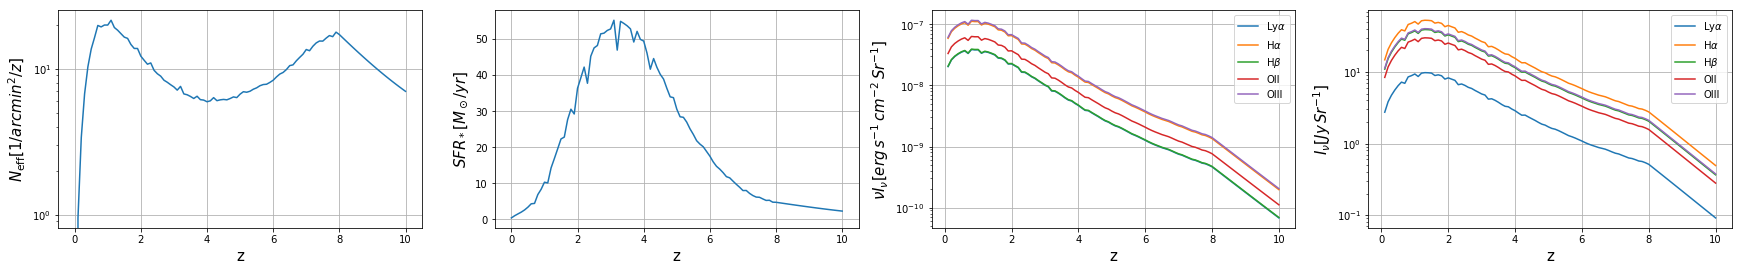

In [1]:
#
from model_F17 import *

dz = 0.1
zbins = np.arange(0,10 + dz,dz)

Neff_arr = np.zeros_like(zbins)
sfrs_arr = np.zeros_like(zbins)
Las_arr = np.zeros_like(zbins)
Has_arr = np.zeros_like(zbins)
Hbs_arr = np.zeros_like(zbins)
O2s_arr = np.zeros_like(zbins)
O3s_arr = np.zeros_like(zbins)

Neffcmv_arr = np.zeros_like(zbins)

df = pd.DataFrame(zbins, columns=['z'])
for i,z in enumerate(zbins):
    Neff = Neff_Be13(z, unit = 'obs')
    Neffcmv = Neff_Be13(z, unit = 'cmv')
    sfrs = SFRs_Be13(z)
    Neff_arr[i] = Neff
    Neffcmv_arr[i] = Neffcmv
    sfrs_arr[i] = sfrs
    Las_arr[i] = Lline_F17('Lya', z, sfr_arr = [sfrs])[0][0]
    Has_arr[i] = Lline_G17('Ha', z, sfr_arr = [sfrs])[0][0]
    Hbs_arr[i] = Lline_G17('Hb', z, sfr_arr = [sfrs])[0][0]
    O2s_arr[i] = Lline_G17('OII', z, sfr_arr = [sfrs])[0][0]
    O3s_arr[i] = Lline_G17('OIII', z, sfr_arr = [sfrs])[0][0]
    
df['Neff'] = Neff_arr
df['SFRs'] = sfrs_arr
df['Lya_Ls'] = Las_arr
df['Ha_Ls'] = Has_arr
df['Hb_Ls'] = Hbs_arr
df['OII_Ls'] = O2s_arr
df['OIII_Ls'] = O3s_arr

df.to_csv('data_internal/Be13NeffSFRs.txt',index=False)


# make a plot to compare with F17 paper
fig, ax = plt.subplots(1,4,figsize = (30,4))
ax[0].plot(zbins, Neff_arr)
ax[0].set_yscale('log')
ax[0].set_xlabel('z', fontsize = 15)
ax[0].set_ylabel(r'$N_{\rm eff} [1/arcmin^2/z]$' ,fontsize = 15)
ax[0].grid()
ax[1].plot(zbins, sfrs_arr)
ax[1].set_xlabel('z', fontsize = 15)
ax[1].set_ylabel(r'$SFR_* [M_\odot / yr]$' ,fontsize = 15)
ax[1].grid()

# calculate nuInu
# Inu = (Ls * Neff) *  DA^2 y / (4pi DL^2)
# y = lambda_obs (1+z) / H(z)
# nuInu = (Ls * Neff) *(c * Da^2 * (1+z)) / (4pi * DL^2 * H(z))

cd = cosmo_dist(zbins)
c = const.c * (1 + zbins) * cd.comoving_distance**2 \
    / (cd.H * cosmo.luminosity_distance(zbins)**2 * 4 * np.pi) / u.sr
c = c.to(u.Mpc**3 / u.h**3 / u.sr / u.cm**2)

nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Las_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'Ly$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Has_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Hbs_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\beta$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O2s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OII')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O3s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OIII')
ax[2].set_yscale('log')
ax[2].set_xlabel('z', fontsize = 15)
ax[2].set_ylabel(r'$\nu I_\nu [erg\,s^{-1}\,cm^{-2}\,Sr^{-1}]$' ,fontsize = 15)
ax[2].legend(loc = 0)
ax[2].grid()

nu_obs = (spec_lines.Lya.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'Ly$\alpha$')
nu_obs = (spec_lines.Ha.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\alpha$')
nu_obs = (spec_lines.Hb.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\beta$')
nu_obs = (spec_lines.OII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OII')
nu_obs = (spec_lines.OIII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OIII')
ax[3].set_yscale('log')
ax[3].set_xlabel('z', fontsize = 15)
ax[3].set_ylabel(r'$I_\nu [Jy\,Sr^{-1}]$' ,fontsize = 15)
ax[3].legend(loc = 0)
ax[3].grid()

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


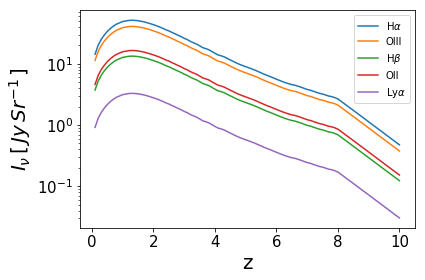

In [18]:
#
from model_F17 import *

dz = 0.1
zbins = np.arange(0,10 + dz,dz)

sfrs_arr = np.zeros_like(zbins)
Las_arr = np.zeros_like(zbins)
Has_arr = np.zeros_like(zbins)
Hbs_arr = np.zeros_like(zbins)
O2s_arr = np.zeros_like(zbins)
O3s_arr = np.zeros_like(zbins)


df = pd.DataFrame(zbins, columns=['z'])
for i,z in enumerate(zbins):
    sfrd = SFRD_Be13(z)
    Las_arr[i] = Lline_F17('Lya', z, sfr_arr = [sfrd])[0][0]
    Has_arr[i] = Lline_G17('Ha', z, sfr_arr = [sfrd])[0][0]
    Hbs_arr[i] = Lline_G17('Hb', z, sfr_arr = [sfrd])[0][0]
    O2s_arr[i] = Lline_G17('OII', z, sfr_arr = [sfrd])[0][0]
    O3s_arr[i] = Lline_G17('OIII', z, sfr_arr = [sfrd])[0][0]

# calculate nuInu
# Inu = (Ls * Neff) *  DA^2 y / (4pi DL^2)
# y = lambda_obs (1+z) / H(z)
# nuInu = (Ls * Neff) *(c * Da^2 * (1+z)) / (4pi * DL^2 * H(z))

cd = cosmo_dist(zbins)
c = const.c * (1 + zbins) * cd.comoving_distance**2 \
    / (cd.H * cosmo.luminosity_distance(zbins)**2 * 4 * np.pi) / u.sr
c = c.to(u.Mpc**3 / u.h**3 / u.sr / u.cm**2)

fig, ax = plt.subplots(1,1, figsize = (6,4))
nuInu_arr = c * (Has_arr * u.L_sun * u.h**3 / u.Mpc**3).to(u.erg / u.second * u.h**3 / u.Mpc**3)
nu_obs = (spec_lines.Ha.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax.plot(zbins, I_arr.value, label = r'H$\alpha$')

nuInu_arr = c * (O3s_arr * u.L_sun * u.h**3 / u.Mpc**3).to(u.erg / u.second * u.h**3 / u.Mpc**3)
nu_obs = (spec_lines.OIII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax.plot(zbins, I_arr.value, label = r'OIII')

nuInu_arr = c * (Hbs_arr * u.L_sun * u.h**3 / u.Mpc**3).to(u.erg / u.second * u.h**3 / u.Mpc**3)
nu_obs = (spec_lines.Hb.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax.plot(zbins, I_arr.value, label = r'H$\beta$')

nuInu_arr = c * (O2s_arr * u.L_sun * u.h**3 / u.Mpc**3).to(u.erg / u.second * u.h**3 / u.Mpc**3)
nu_obs = (spec_lines.OII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax.plot(zbins, I_arr.value, label = r'OII')

nuInu_arr = c * (Las_arr * u.L_sun * u.h**3 / u.Mpc**3).to(u.erg / u.second * u.h**3 / u.Mpc**3)
nu_obs = (spec_lines.Lya.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax.plot(zbins, I_arr.value, label = r'Ly$\alpha$')

ax.set_yscale('log')
ax.set_xlabel('z', fontsize = 20)
ax.set_ylabel(r'$I_\nu\, [\,Jy\,Sr^{-1}\,]$' ,fontsize = 20)
ax.legend(loc = 0, fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.grid()

Why Neff goes down and up in Be13 SFR model?

This can be understood by looking at the SFR(M) as a function as z. Neff is roughly proportional to the HMF at the peak of SFR(M) funciton. The trend of the SFR(M) peak move up and then move down with z, which is consistent with the Neff-z relation.


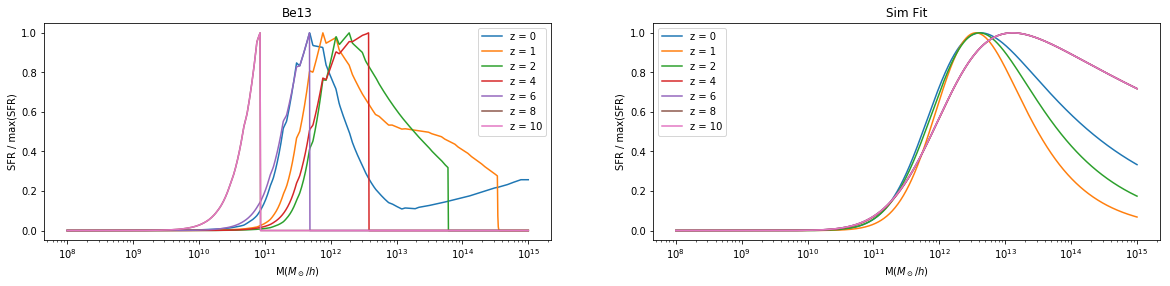

In [31]:
#
from model_F17 import *

fig, ax = plt.subplots(1,2,figsize = (20,4))
for z in [0,1,2,4,6,8,10]:
    SFR_arr,M_arr = SFR_Be13(z)
    ax[0].plot(M_arr, SFR_arr / max(SFR_arr), label = 'z = ' + str(z))
    SFR_arr,M_arr = SFR_F17(z)
    ax[1].plot(M_arr, SFR_arr / max(SFR_arr), label = 'z = ' + str(z))

ax[0].set_xscale('log')
ax[0].set_xlabel('M$(M_\odot/h)$')
ax[0].set_ylabel('SFR / max(SFR)')
ax[0].set_title('Be13')
ax[0].legend()

ax[1].set_xscale('log')
ax[1].set_xlabel('M$(M_\odot/h)$')
ax[1].set_ylabel('SFR / max(SFR)')
ax[1].set_title('Sim Fit')
ax[1].legend()

# Compare SFRD

Text(0,0.5,'log10(SFRD)[$M_\\odot$/ yr / Mpc$^3$]')

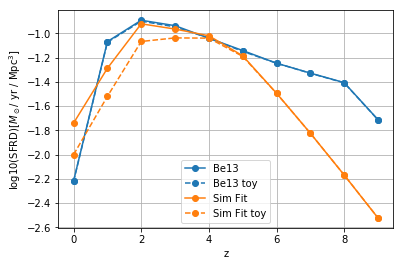

In [33]:
# F17 SFRD
from model_F17 import *

z_arr = np.arange(10, dtype = 'float')
sfrd_arr = np.zeros_like(z_arr)
sfrd_toy_arr = np.zeros_like(z_arr)
for i,z in enumerate(z_arr):
    sfrd_arr[i] = SFRD_Be13(z)
    Neffcmv = Neff_Be13(z, unit = 'cmv')
    sfrs = SFRs_Be13(z)
    sfrd_toy_arr[i] = Neffcmv * sfrs
sfrd_arr *= cosmo.h**3
sfrd_toy_arr *= cosmo.h**3
line = plt.plot(z_arr, np.log10(sfrd_arr),'o-', label = 'Be13')
plt.plot(z_arr, np.log10(sfrd_toy_arr),'o--', c = line[0].get_color(), label = 'Be13 toy')


sfrd_arr = np.zeros_like(z_arr)
sfrd_toy_arr = np.zeros_like(z_arr)
for i,z in enumerate(z_arr):
    sfrd_arr[i] = SFRD_F17(z)
    Neffcmv = Neff_F17(z, unit = 'cmv')
    sfrs = SFRs_F17(z)
    sfrd_toy_arr[i] = Neffcmv * sfrs
sfrd_arr *= cosmo.h**3
sfrd_toy_arr *= cosmo.h**3
line = plt.plot(z_arr, np.log10(sfrd_arr),'o-', label = 'Sim Fit')
plt.plot(z_arr, np.log10(sfrd_toy_arr),'o--', c = line[0].get_color(), label = 'Sim Fit toy')


plt.grid()
plt.legend()
plt.xlabel('z')
plt.ylabel('log10(SFRD)[$M_\odot$/ yr / Mpc$^3$]')

# Write SFR Func to File

In [1]:
#
from model_F17 import *

zbinedges = np.arange(0,10 + 0.01,0.01)
zbins = (zbinedges[1:] + zbinedges[:-1]) / 2
SFRbinedges = np.logspace(-3,1,100)
SFRbins = np.sqrt(SFRbinedges[1:] * SFRbinedges[:-1])
SFRf_arrF = np.zeros([len(zbins), len(SFRbins)])
SFRf_arrBe = np.zeros([len(zbins), len(SFRbins)])
for i,z in enumerate(zbins):
    dndsfr_arr, _, _, _, _ = SFR_func_F17(z, sfr_arr = SFRbins)
    SFRf_arrF[i,:] = dndsfr_arr
    dndsfr_arr, _, _, _, _ = SFR_func_Be13(z, sfr_arr = SFRbins)
    SFRf_arrBe[i,:] = dndsfr_arr

np.save('data_internal/F17SFRfunc', SFRf_arrF)
np.save('data_internal/Be13SFRfunc', SFRf_arrBe)

# Compare F17/G16 L_line / SFR conversion factor

In [6]:
from model_F17 import *
from survey_params import *
sphx_par = spherex_param()

line = 'Ha'
for line in ('Ha', 'OII', 'OIII'):
    LperSFR_F = Lline_F17(line, 0, sfr_arr = [1])[0][0] * u.Lsun.to(u.erg / u.s)
    LperSFR_G = Lline_G17(line, 0, sfr_arr = [1])[0][0] * u.Lsun.to(u.erg / u.s)
    ratio = LperSFR_G/LperSFR_F
    print('%s, L(G17) / L(F17) = %.2f'%(line, ratio))

Ha, L(G17) / L(F17) = 12.35
OII, L(G17) / L(F17) = 8.99
OIII, L(G17) / L(F17) = 17.72


# Comapre H$\alpha$ L*  with Sobral13 Schechter function fit to observation

In [44]:
# Ha L* at z = 2.23
from model_F17 import *
from survey_params import *

sphx_par = spherex_param()

z = 2.23
Ls_Sobral = 10**42.87 # erg / s
sfrsF = SFRs_F17(z)
sfrsBe = SFRs_Be13(z)
Ls_F = Lline_F17('Ha', z, sfr_arr = [sfrsF])[0][0] * u.Lsun.to(u.erg / u.s)
Ls_G = Lline_G17('Ha', z, sfr_arr = [sfrsF])[0][0] * u.Lsun.to(u.erg / u.s)
Ls_Be = Lline_G17('Ha', z, sfr_arr = [sfrsBe])[0][0] * u.Lsun.to(u.erg / u.s)
print('L*(Sim+F17) = %.2e, L*(Sim+G17) = %.2e , L*(Be13+G17) = %.2e, L*(Sobral) = %.2e [erg / s]'\
      %(Ls_F, Ls_G, Ls_Be, Ls_Sobral))

dOm = ((6.2 / 60 / 60)*(np.pi/180))**2 * u.steradian

nu_obs = spec_lines.Ha.to(u.GHz, equivalencies = u.spectral()).value / (1 + z)
idx = np.argmin(abs(sphx_par.nu_bins - nu_obs))
dnu = sphx_par.dnus[idx] * u.GHz

DL = cosmo.luminosity_distance(z)
I_Sobral = (Ls_Sobral * (u.erg / u.s) / 4 / np.pi / DL**2 / dnu / dOm).to(u.Jy / u.sr)
I_F = (Ls_F * (u.erg / u.s) / 4 / np.pi / DL**2 / dnu / dOm).to(u.Jy / u.sr)
I_G = (Ls_G * (u.erg / u.s) / 4 / np.pi / DL**2 / dnu / dOm).to(u.Jy / u.sr)
I_Be = (Ls_Be * (u.erg / u.s) / 4 / np.pi / DL**2 / dnu / dOm).to(u.Jy / u.sr)
I_n = 3631 * 10**(-22  /2.5) * u.Jy / 5 / dOm

print('I*(Sim+F17) = %.2f, I*(Sim+G17) = %.2f , I*(Be13+G17) = %.2f, I*(Sobral) = %.2f [Jy / sr]'\
      %(I_F.value, I_G.value, I_Be.value, I_Sobral.value))
print('SPHEREx-deep In = %.2f [Jy / sr] (directly convert from 5sigma = 22, not consider Neff)'%(I_n.value))

L*(Sim+F17) = 8.60e+40, L*(Sim+G17) = 1.06e+42 , L*(Be13+G17) = 5.44e+42, L*(Sobral) = 7.41e+42 [erg / s]
I*(Sim+F17) = 69.75, I*(Sim+G17) = 861.19 , I*(Be13+G17) = 4414.56, I*(Sobral) = 6015.20 [Jy / sr]
SPHEREx-deep In = 1273.86 [Jy / sr] (directly convert from 5sigma = 22, not consider Neff)


# Neff for SPHEREx pixel size

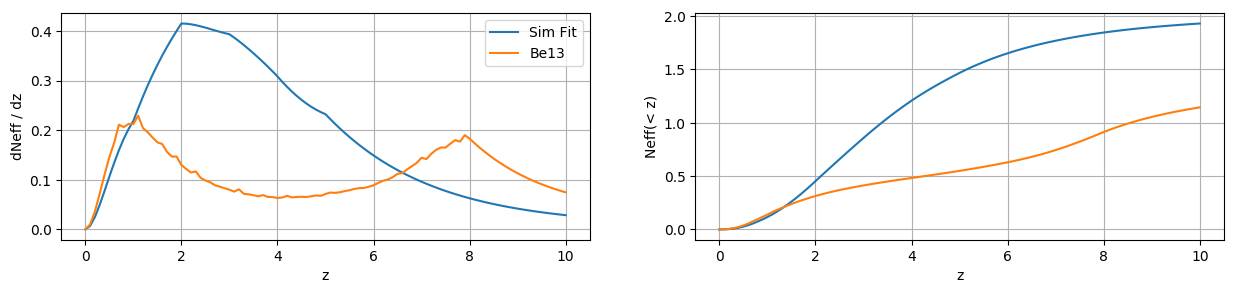

In [47]:
#
from model_F17 import *
from survey_params import *
sphx_par = spherex_param()

fig,ax = plt.subplots(1,2, figsize = (15,3), dpi = 100)

df = pd.read_csv('data_internal/F17NeffSFRs.txt')
z_dat = df['z'].values
Neff_dat = df['Neff'].values * (sphx_par.dth)**2
dz = z_dat[1] - z_dat[0]
ax[0].plot(z_dat, Neff_dat, label = 'Sim Fit')
ax[1].plot(z_dat, np.cumsum(Neff_dat) * dz)

df = pd.read_csv('data_internal/Be13NeffSFRs.txt')
z_dat = df['z'].values
Neff_dat = df['Neff'].values * (sphx_par.dth)**2
dz = z_dat[1] - z_dat[0]
ax[0].plot(z_dat, Neff_dat, label = 'Be13')
ax[1].plot(z_dat, np.cumsum(Neff_dat) * dz)

ax[0].set_ylabel('dNeff / dz')
ax[0].set_xlabel('z')
ax[0].legend(loc = 0)
ax[0].grid()
ax[1].set_ylabel('Neff(< z)')
ax[1].set_xlabel('z')
ax[1].grid()

# SPHEREx NEI and PSF Neff

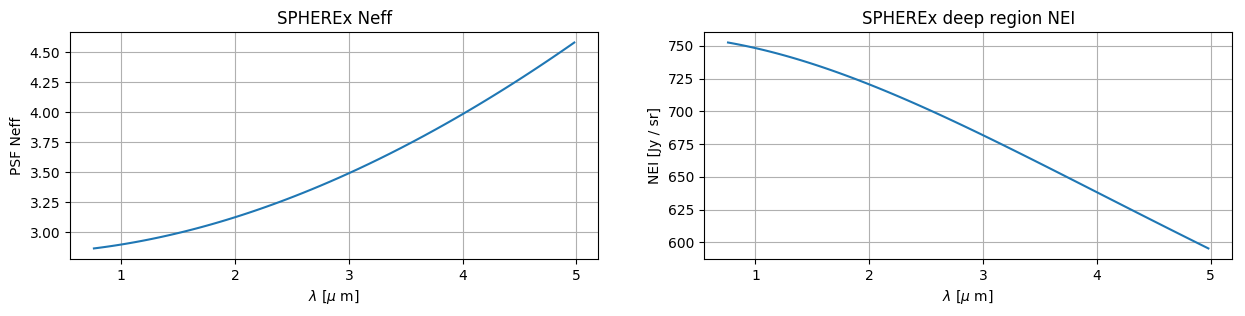

In [14]:
#
from survey_params import *
sphx_par = spherex_param()

fig,ax = plt.subplots(1,2, figsize = (15,3), dpi = 100)
ax[0].plot(sphx_par.wl_bins, sphx_par.Neff)
ax[0].set_ylabel('PSF Neff')
ax[0].set_xlabel(r'$\lambda$ [$\mu$ m]')
ax[0].set_title('SPHEREx Neff')
ax[0].grid()

ax[1].plot(sphx_par.wl_bins, sphx_par.NEI_deep)
ax[1].set_ylabel('NEI [Jy / sr]')
ax[1].set_xlabel(r'$\lambda$ [$\mu$ m]')
ax[1].set_title('SPHEREx deep region NEI')
ax[1].grid()

In [23]:
1/(Lline_F17('Lya', 0, 1)[0]*u.Lsun).to(u.erg/u.s)

<Quantity 2.29444221e-41 s / erg>